# Machine Learning Models for Classification

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'DATA/OSA_DB_class.xlsx'
df = pd.read_excel(file_path)

df_class = df.drop(columns=[ 'Weight', 'Height'])

# Convert Gender into categorical
df_class['Gender'] = df_class['Gender'].astype('category')

print(df_class.dtypes)

df_class.head()


Gender      category
Age          float64
Cervical     float64
BMI          float64
OSA           object
dtype: object


,Gender,Age,Cervical,BMI,OSA
0,1,39.0,40.617735,29.053288,Severe
1,1,46.0,43.000000,29.885548,Severe
2,1,32.0,42.000000,30.193906,Healthy
3,1,39.0,42.000000,30.110991,Severe
4,1,47.0,44.000000,49.012980,Severe


[0]
Original dataset shape: Severe     134
Healthy    106
Name: OSA, dtype: int64
Resampled dataset shape: Severe     134
Healthy    134
Name: OSA, dtype: int64


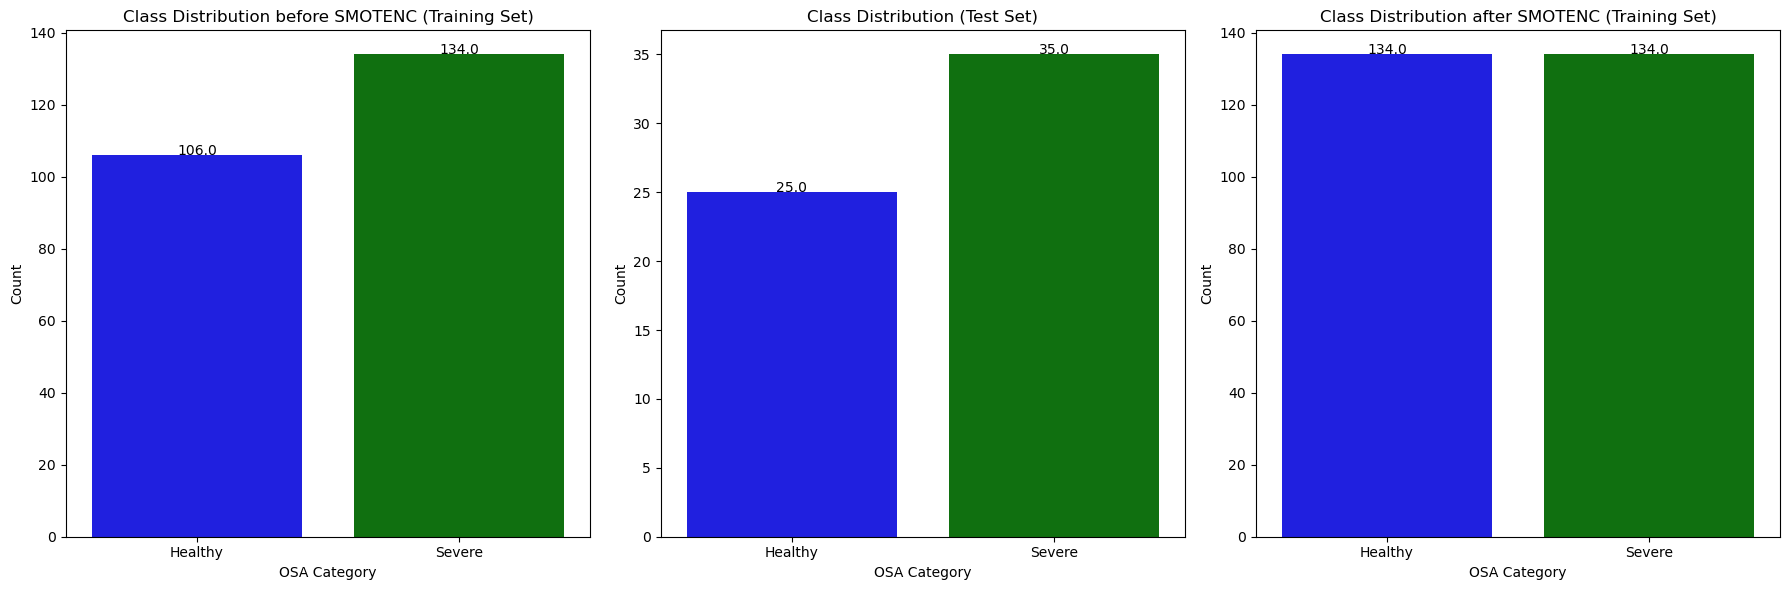

In [24]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'OSA' is the target variable
X = df_class.drop(columns=['OSA'])
y = df_class['OSA']

# Identify the indices of categorical features
categorical_features = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns]
print(categorical_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Verify the resampling
print(f'Original dataset shape: {y_train.value_counts()}')
print(f'Resampled dataset shape: {y_train_resampled.value_counts()}')



# Plot the data distribution before resampling
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(ax=axes[0], x=y_train, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[0].set_title('Class Distribution before SMOTENC (Training Set)')
axes[0].set_xlabel('OSA Category')
axes[0].set_ylabel('Count')

# Annotate the bars with the absolute values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(ax=axes[1], x=y_test, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[1].set_title('Class Distribution (Test Set)')
axes[1].set_xlabel('OSA Category')
axes[1].set_ylabel('Count')
# Annotate the bars with the absolute values
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(ax=axes[2], x=y_train_resampled, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[2].set_title('Class Distribution after SMOTENC (Training Set)')
axes[2].set_xlabel('OSA Category')
axes[2].set_ylabel('Count')
# Annotate the bars with the absolute values
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()
plt.show()


In [32]:
# Perform mapping
y_train_mapped = y_train.map({'Healthy': 0, 'Severe': 1})
y_train_resampled_mapped = y_train_resampled.map({'Healthy': 0, 'Severe': 1})
y = y.map({'Healthy': 0, 'Severe': 1})

# Verify the mapping
print(y_train_mapped.head())
print(y_train_resampled_mapped.head())

232    1
59     1
6      0
185    1
173    1
Name: OSA, dtype: int64
0    1
1    1
2    0
3    1
4    1
Name: OSA, dtype: int64


## Test1


### Wrong: when using data seen in training for testing

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=2, random_state=0)
# X is our training data
clf.fit(X, y)

# This is an overly optimistic estimation since we are using X again!
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)

print(f'Accuracy: {acc:.2f}')

Accuracy: 0.91


### Improvement: split in train and test set 
problem: performance is still sensible to the selection of the test set

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = RandomForestClassifier(n_estimators=2, random_state=0)
clf.fit(X_train, y_train)

# test with unseen data
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.2f}')

Accuracy: 0.67


### Perform Cross-validation to estimate the performance of the model
Good for estimating the generalization error with cross-validation 

In [ ]:
from sklearn.model_selection import cross_validate

def do_cross_validation(clf, print_model=False):
    cv = cross_validate(clf, X, y, scoring='accuracy', cv=5) # splits data into train+validation and test
    scores = ' + '.join(f'{s:.2f}' for s in cv["test_score"])
    mean_ = cv["test_score"].mean()
    msg = f'Cross-validated accuracy: ({scores}) / 3 = {mean_:.2f}'
    
    if print_model:
        msg = f'{clf}:\n\t{msg}\n'
    
    print(msg)

do_cross_validation(clf)

Cross-validated accuracy: (0.70 + 0.60 + 0.65 + 0.70 + 0.68) / 3 = 0.67


In [39]:
from sklearn.svm import SVC

svc = SVC(random_state=0)
do_cross_validation(svc)

Cross-validated accuracy: (0.73 + 0.77 + 0.80 + 0.85 + 0.85) / 3 = 0.80


### Problem: we use the (vanilla) cross-validation method to optimize hyperparameters and model selection
This can lead to an overly optimistic generalization error (due to overfitting) 



In [40]:
do_cross_validation(SVC(kernel='linear', random_state=0), print_model=True)
do_cross_validation(SVC(kernel='poly', random_state=0), print_model=True)
do_cross_validation(RandomForestClassifier(n_estimators=2, random_state=0), print_model=True)
do_cross_validation(RandomForestClassifier(n_estimators=5, random_state=0), print_model=True)

SVC(kernel='linear', random_state=0):
	Cross-validated accuracy: (0.75 + 0.70 + 0.80 + 0.83 + 0.83) / 3 = 0.78

SVC(kernel='poly', random_state=0):
	Cross-validated accuracy: (0.77 + 0.68 + 0.80 + 0.85 + 0.78) / 3 = 0.78

RandomForestClassifier(n_estimators=2, random_state=0):
	Cross-validated accuracy: (0.70 + 0.60 + 0.65 + 0.70 + 0.68) / 3 = 0.67

RandomForestClassifier(n_estimators=5, random_state=0):
	Cross-validated accuracy: (0.78 + 0.68 + 0.77 + 0.83 + 0.73) / 3 = 0.76



### Nested Cross-validation

In [41]:
from sklearn.model_selection import GridSearchCV

# random forest inner loop
clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid={'n_estimators': [2, 5]})

# random forest outer loop
do_cross_validation(clf_grid, print_model=True)

# svc inner loop
svc_grid = GridSearchCV(SVC(random_state=0), param_grid={'kernel': ['linear', 'poly']})

# svc outer loop
do_cross_validation(svc_grid, print_model=True)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': [2, 5]}):
	Cross-validated accuracy: (0.78 + 0.68 + 0.77 + 0.83 + 0.73) / 3 = 0.76

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'kernel': ['linear', 'poly']}):
	Cross-validated accuracy: (0.77 + 0.68 + 0.80 + 0.83 + 0.78) / 3 = 0.77



In [42]:
do_cross_validation(SVC(kernel='linear', random_state=0), print_model=True)
do_cross_validation(SVC(kernel='poly', random_state=0), print_model=True)

SVC(kernel='linear', random_state=0):
	Cross-validated accuracy: (0.75 + 0.70 + 0.80 + 0.83 + 0.83) / 3 = 0.78

SVC(kernel='poly', random_state=0):
	Cross-validated accuracy: (0.77 + 0.68 + 0.80 + 0.85 + 0.78) / 3 = 0.78



## Test2

Average difference of 0.009333 with std. dev. of 0.011069.


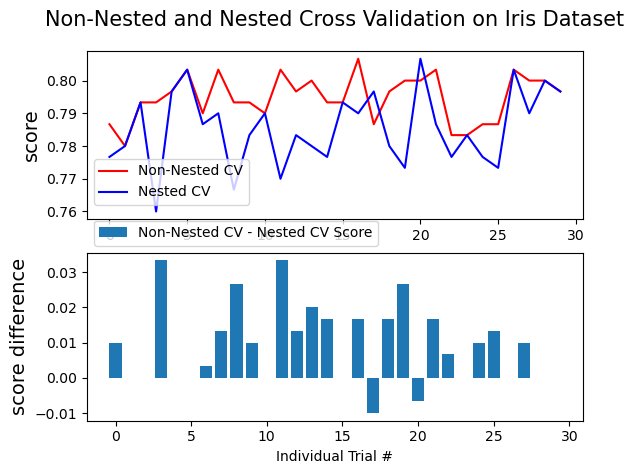

In [45]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i) # splits the train+validation into train and validation
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i) # splits the data into train+validation and test

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv) # inner loop for hyperparameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv) # outer loop for model selection 
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## Test3

### Manual nested cross-validation for random forest on a classification dataset

In [55]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

def Nested_CV_manual(classifier, space):
        
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        # define the model
        model = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # define the model
        model = RandomForestClassifier(random_state=1)
        
        # define search
        search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
        
        # execute search
        result = search.fit(X_train, y_train)
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        
        # store the result
        outer_results.append(acc)
        
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [56]:
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]

Nested_CV_manual(RandomForestClassifier(random_state=1), space)


>acc=0.783, est=0.792, cfg={'max_features': 2, 'n_estimators': 500}
>acc=0.783, est=0.796, cfg={'max_features': 4, 'n_estimators': 100}
>acc=0.783, est=0.800, cfg={'max_features': 2, 'n_estimators': 100}
>acc=0.867, est=0.838, cfg={'max_features': 2, 'n_estimators': 100}
>acc=0.817, est=0.771, cfg={'max_features': 4, 'n_estimators': 100}
Accuracy: 0.807 (0.033)


### Automatic nested cross-validation for random forest on a classification dataset

In [60]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def Nested_CV_automatic(classifier, space):
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', classifier)
    ])
    # define search
    search = GridSearchCV(classifier, space, scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
    # execute the nested cross-validation
    scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


In [61]:
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]

Nested_CV_automatic(RandomForestClassifier(random_state=1), space)

Accuracy: 0.807 (0.033)


## Logistic Regression 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[16  9]
 [ 8 27]]
              precision    recall  f1-score   support

     Healthy       0.67      0.64      0.65        25
      Severe       0.75      0.77      0.76        35

    accuracy                           0.72        60
   macro avg       0.71      0.71      0.71        60
weighted avg       0.72      0.72      0.72        60

